# Readme

Folder Structure

  /project_folder
    IS5126_Guided_Project.ipynb
    /data
      player_salaries.csv
      player_static_info.csv
      season_per_game.csv
      team_info.csv
      team_season_per_game.csv

# Import Libraries

In [75]:
import os
import argparse
import pickle 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import statsmodels.api as sm
import statsmodels.stats.api as sms

from linearmodels import PanelOLS
from linearmodels import RandomEffects
from scipy import stats

In [76]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Define Filepaths

Data Folder Path

In [77]:
DATA_FOLDER = r"./data/"

Data File Paths

In [78]:
SALARY_FILE = os.path.join(DATA_FOLDER, "player_salaries_all.csv")
PLAYER_INFO_FILE = os.path.join(DATA_FOLDER, "player_static_info.csv")
PLAYER_STATS_FILE = os.path.join(DATA_FOLDER, "season_per_game.csv")
TEAM_INFO_FILE = os.path.join(DATA_FOLDER, "team_info.csv")
TEAM_STATS_FILE = os.path.join(DATA_FOLDER, "team_season_per_game.csv")
MAIN_DF_FILE = os.path.join(DATA_FOLDER, "df_main.csv")

# Read Data

In [79]:
df_salary = pd.read_csv (SALARY_FILE, encoding='latin1')
df_player_info = pd.read_csv (PLAYER_INFO_FILE, encoding='latin1')
df_player_stats = pd.read_csv (PLAYER_STATS_FILE, encoding='latin1')
df_team_info = pd.read_csv (TEAM_INFO_FILE, encoding='latin1')
df_team_stats = pd.read_csv (TEAM_STATS_FILE, encoding='latin1')

# Check Data 

In [80]:
df_salary.drop(df_salary.filter(regex="Unnamed"),axis=1, inplace=True)
df_salary.head(1)

,player,season,team,salary
0,Ãlex Abrines,2016-17,Oklahoma City Thunder,5994764


In [81]:
df_player_info.drop(df_player_info.filter(regex="Unnamed"),axis=1, inplace=True)
df_player_info.head(1)

,name,height,birthday,weight
0,Ãlex Abrines,6-2,"August 1, 1993",200lb


In [82]:
df_player_stats.drop(df_player_stats.filter(regex="ï»¿"),axis=1, inplace=True)
df_player_stats.head(1)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,Arron Afflalo,SG,24,DEN,82,75,27.1,3.3,7.1,0.465,...,0.7,2.4,3.1,1.7,0.6,0.4,0.9,2.7,8.8,2009-10


In [83]:
df_team_info.drop(df_team_info.filter(regex="ï»¿"),axis=1, inplace=True)
df_team_info.head(1)

,name,location,team_names,seasons,record,playoff_appearances,championships
0,Philadelphia 76ers,Pennsylvania,"Philadelphia 76ers, Syracuse Nationals",73,0.519,51,3


In [84]:
df_team_stats.drop(df_team_stats.filter(regex="Unnamed"),axis=1, inplace=True)
df_team_stats.head(1)

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,Phoenix Suns,82,240.6,40.7,82.8,0.492,8.9,21.6,0.412,31.8,...,11.1,31.9,43.0,23.3,5.8,5.1,14.8,20.9,110.2,2009-10


# Part B

### Question 1: Put all the relevant data variables into one dataframe. Explain how you clean your dataset and transform your data variable if any and provide a data dictionary for all your variables. (3 points)

Common utility method for coverting dataframe column name to lower case

In [85]:
def _lowercase_colnames(df):
    df.columns = [col.lower() for col in df.columns]
    return df

Convert all dataframe column name to lower case

In [86]:
df_salary = _lowercase_colnames(df=df_salary)
df_player_stats = _lowercase_colnames(df=df_player_stats)
df_team_info = _lowercase_colnames(df=df_team_info)
df_team_stats = _lowercase_colnames(df=df_team_stats)

Standardize dataframe column names for merging

In [87]:
# Update df_salary "team -> team_name"
salary_col = {"team": "team_name"}

# Update df_player_static_info "name -> player"
player_info_col = {"name": "player"}

# Update df_team_stats "for all colname except season -> team_colname"
# Update df_team_stats "team -> team_name"
team_stats_col = {col: "team_"+col for col in df_team_stats.columns}
team_stats_col["team"] = "team_name"
del team_stats_col["season"]

# Update df_team_info "for all colname -> team_colname"
# Update df_team_info "team_names -> full_team_name"
# Update df_team_info "seasons -> team_total_seasons"
team_info_col = {col: "team_"+col for col in df_team_info.columns}
team_info_col["team_names"] = "full_team_name"
team_info_col["seasons"] = "team_total_seasons"

Renaming of column names in dataset

In [88]:
df_salary = df_salary.rename(columns=salary_col)
df_player_info = df_player_info.rename(columns=player_info_col)
df_team_stats = df_team_stats.rename(columns=team_stats_col)
df_team_info = df_team_info.rename(columns=team_info_col)

Merge salary and player statistics (outer join)

In [89]:
df_main = df_salary.merge(df_player_stats,
                     how="outer",
                     on=["player", "season"])

Get active players from 2009/2010 to 2020/2021 seasons

In [90]:
df_main["season_year"] = df_main["season"].str.split("-").str[0].astype(int)
df_active = df_main.loc[(df_main["season_year"]>=2009)
                    &(df_main["season_year"]<=2020), :]
df_active = pd.DataFrame(df_active.loc[:, "player"])

Get unique active players

In [91]:
df_active = df_active.drop_duplicates(subset=["player"], keep="first")

Merge with main df to get statistics of active players only

In [92]:
df_main = df_main.merge(df_active,
              how="inner",
              on=["player"])

Convert player height and weight

In [93]:
# Convert height into cm
df_height_info = df_player_info["height"].str.split("-")
df_player_info["height"] = df_height_info.str[0].astype(int) * 30.48 + df_height_info.str[1].astype(int) * 2.54

# Replace null with "0lb"
df_weight_info = df_player_info["weight"].fillna("0lb", inplace = True)
# convery weight into kg
df_weight_info = df_player_info["weight"].str.split("lb").str[0].astype(int)
df_player_info["weight"] = df_weight_info * 0.453592


Drop birthday column

In [94]:
df_player_info = df_player_info.drop(columns=["birthday"])

Merge with main df to get height and weight of players

In [95]:
df_main = df_main.merge(df_player_info,
              how="left",
              on=["player"])

Get experience for each player

In [96]:
df_exp = (df_main.groupby("player")
            .agg({"season_year": [np.min, np.max]})
            .reset_index(drop=False))
df_exp.columns = ["player", "start_year", "latest_year"]
df_exp["experience"] = df_exp["latest_year"] - df_exp["start_year"]

Merge with main df to get experience of active players only

In [97]:
df_main = df_main.merge(df_exp,
              how="inner",
              on=["player"])

Get total salary for each player

In [98]:
df_total_salary = df_salary.groupby("player").agg({"salary": "sum"})
df_total_salary = df_total_salary.reset_index(drop=False)
df_total_salary.columns = ["player", "total_salary"]

Merge with main df to get total salary of active players only

In [99]:
df_main = df_main.merge(df_total_salary,
              how="left",
              on=["player"])

Get Year-To-Date experience

In [100]:
df_main["experience_YTD"] = df_main["season_year"] - df_main["start_year"]

Rename old team names with the new team name

In [101]:
df_main["team_name"] = df_main["team_name"].str.replace("New Orleans Hornets", "New Orleans Pelicans", regex=False)
df_main["team_name"] = df_main["team_name"].str.replace("Charlotte Bobcats", "Charlotte Hornets", regex=False)
df_main["team_name"] = df_main["team_name"].str.replace("New Jersey Nets", "Brooklyn Nets", regex=False)

df_team_stats["team_name"] = df_team_stats["team_name"].str.replace("New Orleans Hornets", "New Orleans Pelicans", regex=False)
df_team_stats["team_name"] = df_team_stats["team_name"].str.replace("Charlotte Bobcats", "Charlotte Hornets", regex=False)
df_team_stats["team_name"] = df_team_stats["team_name"].str.replace("New Jersey Nets", "Brooklyn Nets", regex=False)

Merge team info and team stats

In [102]:
df_team_info = df_team_info.merge(df_team_stats,
                                  how="inner",
                                  on=["team_name"])

Merge with main df to get team info

In [103]:
df_main = df_main.merge(df_team_info,
              how="inner",
              on=["team_name", "season"])

Drop unmatched rows with partial data

In [104]:
df_main = df_main.dropna(how="any")

Convert missing values "<s+>" to None

In [105]:
df_main = df_main.replace(r"^\s*$", np.nan, regex=True)

Check if any columns with missing values

In [106]:
missing_cols = df_main.columns[df_main.isnull().any()]
print("Columns with missing values: {}".format(missing_cols))

Columns with missing values: Index([], dtype='object')


Update missing values with 0 

In [107]:
df_main = df_main.fillna(0)

Convert numeric columns to numeric (brute force)

In [108]:
for col in list(df_main.columns):
    try:
        df_main[col] = df_main[col].astype(float)
    except ValueError:
        continue

Number of teams playing for per season

In [109]:
df_num_teams = (df_main.groupby(["player", "season"])
                  .agg({"team_name": pd.Series.nunique})
                  .reset_index(drop=False)
                  .rename(columns={"team_name": "team_count"}))
df_main = df_main.merge(df_num_teams,
              how="inner",
              on=["player", "season"]).reset_index(drop=True)

Get YTD age

In [110]:
MOST_CURRENT_SEASON = 2020
df_main["age_YTD"] = df_main["age"] - (MOST_CURRENT_SEASON - df_main["season_year"])

Reset Index

In [111]:
df_main = df_main.reset_index(drop=True)
df_main.to_csv(MAIN_DF_FILE,index=False)

### Question 2a: For the most current season in the dataset, how many active players are there?

Subset data to retrive most current season 

In [572]:
df_current = df_main.loc[df_main["season_year"]==MOST_CURRENT_SEASON, :]

Get number of active players

In [573]:
active_players = df_current["player"].unique()
print("Number of active players: {}".format(len(active_players)))

Number of active players: 400


### Question 2b: For the most current season in the dataset, how many players in each position?

Get number of players in each position

In [574]:
position_brkdown = (df_current.groupby(["pos"])
                              .agg({"player": pd.Series.nunique})
                              .reset_index(drop=False))
print("Positions: ")
position_brkdown

Positions: 


,pos,player
0,C,71
1,C-PF,1
2,PF,93
3,PF-SF,1
4,PG,75
5,PG-SG,1
6,SF,73
7,SF-PF,2
8,SF-SG,3
9,SG,99


### Question 2c: For the most current season in the dataset, what is the average age, weight, experience, salary in the season?

Get average age, weight, experience, salary

In [575]:
group_cols = ["player", "age", "weight", "experience"]
df_average = df_current.groupby(group_cols).agg({"salary": "sum"})
df_average = df_average.reset_index(drop=False)
print(df_average.describe().loc["mean"])

age           2.594750e+01
weight        9.861884e+01
experience    4.817500e+00
salary        1.122850e+07
Name: mean, dtype: float64


### Question 2d: For the most current season in the dataset, what is average career salary?

Get average career salary

In [576]:
df_average_career = (df_current.groupby(["player", "total_salary"])
                               .agg({"pos": "count"})
                               .reset_index(drop=False))

average_career_salary = df_average_career["total_salary"].mean()
print("Average career salary: {}".format(average_career_salary))

Average career salary: 43464528.86


### Question 3a: How many players were active in each season? What is the average salary by season? How about variance of salary be season?

Get number of players per season

In [577]:
season_players = (df_main.groupby(["season"])
                    .agg({"player": pd.Series.nunique})
                    .reset_index(drop=False))
print("Number of players per season:")
season_players

Number of players per season:


,season,player
0,2009-10,331
1,2010-11,347
2,2011-12,352
3,2012-13,373
4,2013-14,322
5,2014-15,386
6,2015-16,391
7,2016-17,400
8,2017-18,392
9,2018-19,395


Get salary statistics per season

In [578]:
season_salary = (df_main.groupby(["season"])
                   .agg({"salary": ["mean", "var"]})
                   .reset_index(drop=False))
season_salary.columns = ["season", "mean_salary", "var_salary"]
print("Average salary per season:")
season_salary.loc[:, ["season", "mean_salary"]]

Average salary per season:


,season,mean_salary
0,2009-10,4.364733e+06
1,2010-11,4.404918e+06
2,2011-12,4.334382e+06
3,2012-13,3.966301e+06
4,2013-14,4.785412e+06
5,2014-15,3.882502e+06
6,2015-16,4.538129e+06
7,2016-17,5.466605e+06
8,2017-18,6.144456e+06
9,2018-19,7.121715e+06


In [579]:
print("Variance of salary per season:")
season_salary.loc[:, ["season", "var_salary"]]

Variance of salary per season:


,season,var_salary
0,2009-10,1.765357e+13
1,2010-11,2.174283e+13
2,2011-12,1.926788e+13
3,2012-13,1.825702e+13
4,2013-14,2.096707e+13
5,2014-15,2.068466e+13
6,2015-16,2.660031e+13
7,2016-17,3.726963e+13
8,2017-18,5.138882e+13
9,2018-19,6.065052e+13


### Question 3b: who are the top 10% best paid players in the most current season? Which teams did these players play for?

Get total salary per player for current season

In [453]:
df_current_salary = (df_current.groupby(["player"])
                               .agg({"salary": "sum"})
                               .reset_index(drop=False))

Get players in the top 10% salary cap

In [454]:
ten_pct = int(0.1 * df_current_salary.shape[0])
df_current_salary = (df_current_salary.sort_values(by=["salary"],
                                                   ascending=False)
                                      .reset_index(drop=True))
top_10pct = df_current_salary.loc[:ten_pct, "player"]
print("Top 10 percent players: {}".format(top_10pct.to_list()))

Top 10 percent players: ['James Harden', 'Blake Griffin', 'Otto Porter Jr.', 'Victor Oladipo', 'Andre Drummond', 'Gary Harris', 'Aaron Gordon', 'LaMarcus Aldridge', 'Gorgui Dieng', 'Evan Fournier', 'Caris LeVert', 'James Johnson', 'Stephen Curry', 'Russell Westbrook', 'Chris Paul', 'John Wall', 'Kevin Durant', 'LeBron James', 'J.J. Redick', 'Kelly Olynyk', 'Cory Joseph', 'Taurean Prince', 'Paul George', 'Mike Conley', 'Kawhi Leonard', 'Kemba Walker', 'Jimmy Butler', 'Tobias Harris', 'Kyrie Irving', 'Khris Middleton', 'Anthony Davis', 'Norman Powell', 'Damian Lillard', 'Kevin Love', 'Ben Simmons', 'Pascal Siakam', 'Kyle Lowry', 'Rodney Hood', 'Steven Adams', 'Joel Embiid', 'Nikola JokiÄ\x87']


Get the teams of the players in the top 10% salary cap

In [455]:
df_teams_top_10pct = df_current.merge(top_10pct.to_frame(),
                                      how="inner",
                                      on=["player"])
df_teams_top_10pct = df_teams_top_10pct.loc[:, ["player", "team_name"]]
df_teams_top_10pct = df_teams_top_10pct.drop_duplicates(keep="first")
df_teams_top_10pct = (df_teams_top_10pct.groupby(["player"])
                                        .agg({"team_name": list})
                                        .reset_index(drop=False))
print("Teams the top 10 percent plays for:")
df_teams_top_10pct

Teams the top 10 percent plays for:


,player,team_name
0,Aaron Gordon,[Denver Nuggets]
1,Andre Drummond,"[Cleveland Cavaliers, Los Angeles Lakers]"
2,Anthony Davis,[Los Angeles Lakers]
3,Ben Simmons,[Philadelphia 76ers]
4,Blake Griffin,"[Brooklyn Nets, Detroit Pistons]"
5,Caris LeVert,[Indiana Pacers]
6,Chris Paul,[Phoenix Suns]
7,Cory Joseph,[Detroit Pistons]
8,Damian Lillard,[Portland Trail Blazers]
9,Evan Fournier,[Boston Celtics]


### Question 3c: who are the bottom 10% best paid players in the most current season? Which teams did these players play for?

Get players in the bottom 10% salary cap

In [456]:
df_current_salary = (df_current_salary.sort_values(by=["salary"],
                                                   ascending=True)
                                      .reset_index(drop=True))
btm_10pct = df_current_salary.loc[:ten_pct, "player"]
print("Bottom 10 percent players: {}".format(btm_10pct.to_list()))

Bottom 10 percent players: ['Cameron Oliver', 'Isaiah Thomas', 'Mamadi Diakite', 'Henry Ellenson', 'Robert Franks', 'Justin Robinson', 'Andre Roberson', 'Thon Maker', 'Bruno Caboclo', 'Rondae Hollis-Jefferson', 'Tim Frazier', 'Anthony Tolliver', 'Alize Johnson', 'Deividas Sirvydis', 'Jordan Nwora', 'Kenyon Martin Jr.', 'Sam Merrill', 'Isaiah Joe', 'Tre Jones', 'Daniel Oturu', 'CJ Elleby', 'Anthony Gill', 'Elijah Hughes', 'Glenn Robinson III', "Jahmi'us Ramsey", 'Nick Richards', 'Khyri Thomas', 'Ersan Ä°lyasova', 'Tyrell Terry', 'Xavier Tillman Sr.', 'Vernon Carey Jr.', 'Yogi Ferrell', "Jae'Sean Tate", 'Robert Woodard II', 'Naz Reid', 'Eric Paschall', 'Juwan Morgan', 'Jalen McDaniels', 'Mychal Mulder', 'Isaiah Roby', 'Talen Horton-Tucker']


Get the teams of the players in the bottom 10% salary cap

In [457]:
df_teams_btm_10pct = df_current.merge(btm_10pct.to_frame(),
                                      how="inner",
                                      on=["player"])
df_teams_btm_10pct = df_teams_btm_10pct.loc[:, ["player", "team_name"]]
df_teams_btm_10pct = df_teams_btm_10pct.drop_duplicates(keep="first")
df_teams_btm_10pct = (df_teams_btm_10pct.groupby(["player"])
                                        .agg({"team_name": list})
                                        .reset_index(drop=False))
print("Teams the bottom 10 percent plays for:")
df_teams_btm_10pct

Teams the bottom 10 percent plays for:


,player,team_name
0,Alize Johnson,[Brooklyn Nets]
1,Andre Roberson,[Brooklyn Nets]
2,Anthony Gill,[Washington Wizards]
3,Anthony Tolliver,[Philadelphia 76ers]
4,Bruno Caboclo,[Houston Rockets]
5,CJ Elleby,[Portland Trail Blazers]
6,Cameron Oliver,[Houston Rockets]
7,Daniel Oturu,[Los Angeles Clippers]
8,Deividas Sirvydis,[Detroit Pistons]
9,Elijah Hughes,[Utah Jazz]


### Question 3d: who are the middle 50% by salary? Which teams did they play for?

In [458]:
q75, q25 = np.percentile(df_current_salary['salary'], [75 ,25])
df_mid50 = df_current_salary[df_current_salary['salary'].between(q25, q75)]
print(df_mid50)

               player      salary
100     Kent Bazemore   2320044.0
101  Hassan Whiteside   2320044.0
102    Reggie Jackson   2331593.0
103     E'Twaun Moore   2331593.0
104   Markieff Morris   2331593.0
..                ...         ...
295     Malik Beasley  13425895.0
296      Marcus Smart  13446428.0
297     Terrence Ross  13500000.0
298       Patty Mills  13535714.0
299    Thaddeus Young  13545000.0

[200 rows x 2 columns]


Get the teams of the players in the bottom 10% salary cap

In [459]:
df_teams_mid_50pct = df_current.merge(df_mid50,
                                      how="inner",
                                      on=["player"])
df_teams_mid_50pct = df_teams_mid_50pct.loc[:, ["player", "team_name"]]
df_teams_mid_50pct = df_teams_mid_50pct.drop_duplicates(keep="first")
df_teams_mid_50pct = (df_teams_mid_50pct.groupby(["player"])
                                        .agg({"team_name": list})
                                        .reset_index(drop=False))
print("Middle 50% of players")
df_teams_mid_50pct

Middle 50% of players


,player,team_name
0,Aaron Holiday,[Indiana Pacers]
1,Aaron Nesmith,[Boston Celtics]
2,Alec Burks,[New York Knicks]
3,Aleksej Pokusevski,[Oklahoma City Thunder]
4,Alex Len,"[Toronto Raptors, Washington Wizards]"
...,...,...
195,Wes Iwundu,[New Orleans Pelicans]
196,Wesley Matthews,[Los Angeles Lakers]
197,Willie Cauley-Stein,[Dallas Mavericks]
198,Zeke Nnaji,[Denver Nuggets]


### Question 3e: over the career of each of the active players in the most current season, how much money was paid to by season?

Get breakdown of salary per season for players active in current season

In [460]:
df_active_player_career = df_main.merge(pd.DataFrame(active_players, columns=["player"]),
                                   how="inner",
                                   on=["player"])
df_active_salary_season = (df_active_player_career.groupby(["player", "season"])
                                                  .agg({"salary": "sum"})
                                                  .reset_index(drop=False))
print("Salary of active players per season:")
df_active_salary_season

Salary of active players per season:


,player,season,salary
0,Aaron Gordon,2014-15,3992040.0
1,Aaron Gordon,2015-16,4171680.0
2,Aaron Gordon,2016-17,4351320.0
3,Aaron Gordon,2017-18,5504420.0
4,Aaron Gordon,2018-19,21590909.0
...,...,...,...
2110,Zach LaVine,2019-20,19500000.0
2111,Zach LaVine,2020-21,19500000.0
2112,Zeke Nnaji,2020-21,2379840.0
2113,Zion Williamson,2019-20,9757440.0


### Question 4a: what is the average salary of each team by season?

Get average salary per team per season

In [461]:
df_team_salary = (df_main.groupby(["team_name", "season"])
                    .agg({"salary": "mean"})
                    .reset_index(drop=False))
print("Average salary per team per season:")
df_team_salary

Average salary per team per season:


,team_name,season,salary
0,Atlanta Hawks,2009-10,5.393407e+06
1,Atlanta Hawks,2010-11,5.373799e+06
2,Atlanta Hawks,2011-12,4.942871e+06
3,Atlanta Hawks,2012-13,3.502022e+06
4,Atlanta Hawks,2013-14,4.200021e+06
...,...,...,...
355,Washington Wizards,2016-17,5.147514e+06
356,Washington Wizards,2017-18,7.714084e+06
357,Washington Wizards,2018-19,7.953608e+06
358,Washington Wizards,2019-20,5.060215e+06


### Question 4b: what is the average age of the players by season? Average and variance of experience by season of each team?

Get average age and experience per team per season

In [462]:
df_team_age_exp = (df_main.groupby(["team_name", "season"])
                     .agg({"age": "mean",
                           "experience_YTD": ["mean", "var"]})
                     .reset_index(drop=False))
df_team_age_exp.columns = ["team_name", "season", "age", "mean_exp", "var_exp"]
print("Statistics of teams per season:")
df_team_age_exp

Statistics of teams per season:


,team_name,season,age,mean_exp,var_exp
0,Atlanta Hawks,2009-10,27.083333,6.416667,16.446970
1,Atlanta Hawks,2010-11,27.187500,5.437500,7.729167
2,Atlanta Hawks,2011-12,27.538462,5.384615,24.423077
3,Atlanta Hawks,2012-13,28.850000,7.000000,12.947368
4,Atlanta Hawks,2013-14,25.846154,4.615385,17.423077
...,...,...,...,...,...
355,Washington Wizards,2016-17,25.500000,3.944444,8.408497
356,Washington Wizards,2017-18,27.714286,6.571429,9.802198
357,Washington Wizards,2018-19,26.538462,5.846154,17.015385
358,Washington Wizards,2019-20,25.250000,3.900000,15.463158


### Question 4c: provide the information in b. in a "cross-tabulation" format, i.e. teams are on rows and seasons are on columns, and statistics are cell values.

Get average age and experience per team per season (cross-tabulation)

In [463]:
df_cross_tab = df_team_age_exp.pivot(index=["team_name"], columns=["season"], values=["age", "mean_exp", "var_exp"])
print("Statistics of teams per season (cross-tabulated):")
df_cross_tab

Statistics of teams per season (cross-tabulated):


age                                              \
season                    2009-10    2010-11    2011-12    2012-13    2013-14   
team_name                                                                       
Atlanta Hawks           27.083333  27.187500  27.538462  28.850000  25.846154   
Boston Celtics          26.187500  25.000000  26.000000  25.875000  25.466667   
Brooklyn Nets           26.833333  26.066667  26.750000  28.250000  28.600000   
Charlotte Hornets       25.428571  25.105263  25.687500  25.315789  26.133333   
Chicago Bulls           26.944444  27.300000  29.000000  27.428571  26.800000   
Cleveland Cavaliers     26.526316  25.857143  24.833333  24.840000  24.083333   
Dallas Mavericks        29.125000  28.307692  29.900000  30.217391  29.250000   
Denver Nuggets          28.142857  25.052632  26.500000  25.571429  26.941176   
Detroit Pistons         26.166667  26.000000  27.071429  26.142857  26.166667   
Golden State Warriors   25.764706  26.294118  24.555556  26.166667  25.785714   
Houston Rockets         25.863636  25.611111  24.500000  25.111111  26.846154   
Indiana Pacers          26.875000  26.375000  26.545455  25.857143  26.500000   
Los Angeles Clippers    26.350000  26.388889  27.388889  29.888889  28.000000   
Los Angeles Lakers      27.400000  29.333333  29.133333  28.181818  29.600000   
Memphis Grizzlies       24.944444  25.571429  25.941176  25.777778  27.785714   
Miami Heat              28.000000  30.833333  28.000000  28.615385  30.250000   
Milwaukee Bucks         27.600000  26.750000  27.117647  27.176471  26.666667   
Minnesota Timberwolves  25.000000  23.500000  24.692308  25.944444  24.466667   
New Orleans Pelicans    26.875000  27.000000  24.666667  24.615385  24.363636   
New York Knicks         26.384615  27.900000  27.333333  29.444444  29.846154   
Oklahoma City Thunder   23.733333  25.461538  25.615385  27.687500  26.545455   
Orlando Magic           27.555556  27.133333  26.250000  25.350000  25.785714   
Philadelphia 76ers      23.923077  25.181818  25.800000  25.136364  25.055556   
Phoenix Suns            25.625000  28.076923  27.909091  25.466667  27.066667   
Portland Trail Blazers  26.866667  26.153846  27.000000  24.666667  25.714286   
Sacramento Kings        26.000000  24.777778  24.400000  25.555556  27.000000   
San Antonio Spurs       30.083333  26.583333  26.923077  26.529412  27.692308   
Toronto Raptors         24.200000  24.083333  27.071429  25.937500  25.666667   
Utah Jazz               25.200000  26.769231  25.923077  25.636364  25.400000   
Washington Wizards      28.181818  26.678571  26.285714  26.681818  26.142857   

                                                                               \
season                    2014-15    2015-16    2016-17    2017-18    2018-19   
team_name                                                                       
Atlanta Hawks           27.941176  29.176471  30.576923  28.000000  27.105263   
Boston Celtics          26.291667  26.857143  25.571429  24.615385  26.437500   
Brooklyn Nets           26.785714  27.315789  26.343750  26.041667  26.409091   
Charlotte Hornets       26.086957  26.058824  26.000000  25.133333  26.375000   
Chicago Bulls           28.818182  27.588235  26.000000  26.833333  25.227273   
Cleveland Cavaliers     28.000000  28.812500  30.545455  28.217391  25.692308   
Dallas Mavericks        28.100000  29.944444  26.900000  26.875000  28.666667   
Denver Nuggets          26.400000  25.857143  25.350000  28.789474  24.583333   
Detroit Pistons         27.272727  25.944444  25.083333  27.650000  25.826087   
Golden State Warriors   27.384615  28.153846  29.533333  29.384615  28.363636   
Houston Rockets         28.357143  27.666667  28.428571  29.900000  28.823529   
Indiana Pacers          28.000000  26.388889  27.125000  27.937500  27.263158   
Los Angeles Clippers    28.294118  29.384615  30.250000  27.055556  27.761905   
Los Angeles Lakers      25.384615  26.909091  26.909091  26.

### Question 5: What other data from the website can you use to explain salary? Produce a table of summary statistics for key variables you shall use in your analysis in the following Part C. Summary statistics should include at least sample average, standard deviation, min/max. (5 points)

Other data used to explain Salary

One hot encode for column "pos"

In [464]:
pos_dummies = pd.get_dummies(df_main["pos"])
df_main = df_main.merge(pos_dummies,
              how="inner",
              left_index=True,
              right_index=True).reset_index(drop=True)

One hot encode for column "season_year"

In [465]:
season_year_dummies = pd.get_dummies(df_main["season_year"].astype(int).astype(str))
df_main = df_main.merge(season_year_dummies,
              how="inner",
              left_index=True,
              right_index=True).reset_index(drop=True)

Key columns

In [466]:
key_cols = list(df_main.columns)
key_cols.remove("age")
key_cols.remove("total_salary")
key_cols.remove("player")
key_cols.remove("season")
key_cols.remove("season_year")
key_cols.remove("team_name")
key_cols.remove("pos")
key_cols.remove("start_year")
key_cols.remove("full_team_name")
key_cols.remove("latest_year")
key_cols.remove("team_location")
key_cols.remove("experience")
key_cols.remove("team_total_seasons")
key_cols.remove("team_championships")
key_cols.remove("team_playoff_appearances")
key_cols.remove("team_g")
key_cols.remove("team_mp")
key_cols.remove("team_record")
key_cols.remove("team_fg")
key_cols.remove("tm")

In [467]:
df_final = df_main.loc[:, key_cols]

Summary Statistics of Variables

In [580]:
print("Summary statistics:")
df_final.describe()

Summary statistics:


,salary,g,gs,mp,fg,fga,fg%,3p,3pa,3p%,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,6.182000e+03,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,...,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000
mean,5.469368e+06,48.423002,22.844387,21.196182,3.297638,7.425655,0.435660,0.830767,2.372841,0.299397,...,0.067777,0.079262,0.067130,0.093497,0.087836,0.089939,0.087997,0.098188,0.087512,0.093012
std,6.442880e+06,23.960359,26.778213,8.626955,2.039023,4.278260,0.074927,0.741982,1.911411,0.138457,...,0.251384,0.270170,0.250268,0.291152,0.283079,0.286117,0.283314,0.297593,0.282607,0.290473
min,4.608000e+03,1.000000,0.000000,2.100000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.227985e+06,27.000000,1.000000,14.400000,1.700000,4.100000,0.399000,0.200000,0.800000,0.256000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.967060e+06,52.000000,10.000000,21.000000,2.900000,6.600000,0.434000,0.700000,2.100000,0.333000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.420912e+06,70.000000,42.000000,28.200000,4.500000,10.000000,0.473000,1.300000,3.500000,0.375000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.300636e+07,83.000000,82.000000,41.400000,11.200000,24.500000,0.833000,5.300000,13.200000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [469]:
df_final.columns
df_final.to_csv(OUTPUT_FILE_FINAL,index=False)

Index(['salary', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p',
       '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'height', 'weight', 'experience_YTD',
       'team_fga', 'team_fg%', 'team_3p', 'team_3pa', 'team_3p%', 'team_2p',
       'team_2pa', 'team_2p%', 'team_ft', 'team_fta', 'team_ft%', 'team_orb',
       'team_drb', 'team_trb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
       'team_pf', 'team_pts', 'team_count', 'age_YTD', 'C', 'C-PF', 'PF',
       'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-C', 'SF-PF', 'SF-SG', 'SG',
       'SG-PF', 'SG-PG', 'SG-SF', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

# Part C

Understanding distribution of salary

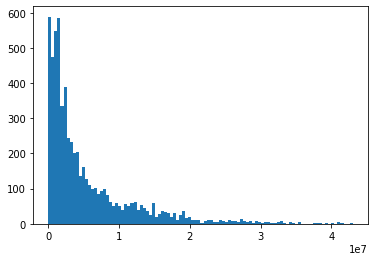

In [470]:
plt.hist(df_final["salary"], bins=100)
plt.show()

## Question 1: Clustering. Which players are similar?

### Question 1a: Apply "k-means" algorithm.

Metric for evaluation: Silhouette Score
    
    Silhouette Coefficient = (x-y)/ max(x,y)
    where x = mean intercluster distance and y = mean intracluster distance

Define cluster sizes

In [471]:
n_clusters = range(2, 22)

Form clusters using salary

In [472]:
df_salary_clusters = df_final.loc[:, "salary"].to_frame()
df_salary_kmeans = df_final.loc[:, "salary"].to_frame()

Fit Kmeans to salary to identify optimal clusters

In [473]:
for n_cluster in n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_salary_kmeans)
    df_salary_clusters["cluster_{}".format(n_cluster)] = kmeans.labels_

Evaluate similarity of salary clusters

In [474]:
all_salary_scores = []

for n_cluster in n_clusters:
    score = silhouette_score(df_salary_clusters["salary"].to_frame(), df_salary_clusters["cluster_{}".format(n_cluster)])
    all_salary_scores.append(score)

In [475]:
all_salary_scores

[0.7317497390791429,
 0.6829984582277977,
 0.643933940136239,
 0.6044375743139744,
 0.5920074097207878,
 0.5964446091337381,
 0.5688638549720192,
 0.5706504515465296,
 0.5489301775601618,
 0.5476039280627018,
 0.5488314086713463,
 0.5489873720504765,
 0.5381611197769763,
 0.5412373661492274,
 0.5569756482521401,
 0.5507634346457312,
 0.5503472696189785,
 0.553292359360914,
 0.5714521906978259,
 0.5692830791212563]

Get predictors

In [476]:
df_kmeans = df_final.drop(columns=["salary"])
df_kmeans_clusters = df_final.drop(columns=["salary"])
df_kmeans_cols = df_kmeans.columns

Normalize predictors

In [477]:
scaler = StandardScaler()
df_kmeans = pd.DataFrame(scaler.fit_transform(df_kmeans), columns=df_kmeans_cols)

Random selection of predictors

In [478]:
def _generate_random_predictors(df_kmeans):
    size_pct = float(np.random.randint(low=0, high=100))/100
    size = max(int(df_kmeans.shape[1] * size_pct), 1)
    features = np.random.choice(list(df_kmeans.columns), size=size, replace=False)
    
    return df_kmeans.loc[:, features]

Define number of random selections of predictors

In [479]:
n_feature_selection = range(50)

Fit Kmeans

In [480]:
all_feature_clusters = []

for i in n_feature_selection:
    df_features = _generate_random_predictors(df_kmeans=df_kmeans)
    
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_features)
        
        feature_cluster = (list(df_features.columns), kmeans.labels_, n_cluster)
        all_feature_clusters.append(feature_cluster)

<ipython-input-480-46bdee1f7861>:7: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_features)
<ipython-input-480-46bdee1f7861>:7: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_features)
<ipython-input-480-46bdee1f7861>:7: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_features)
<ipython-input-480-46bdee1f7861>:7: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_features)


Evaluate similarity of players in clusters

In [481]:
player_similarity = []
salary_similarity = []

for feature_cluster in all_feature_clusters:
    df_subset = df_kmeans.loc[:, feature_cluster[0]]
    player_score = silhouette_score(df_subset, feature_cluster[1])
    salary_score = silhouette_score(df_salary_kmeans, feature_cluster[1])
    
    player_similarity.append([feature_cluster[0], feature_cluster[2], player_score])
    salary_similarity.append([feature_cluster[0], feature_cluster[2], salary_score])

Identify best combination

In [482]:
player_similarity = sorted(player_similarity, key=lambda x: x[2], reverse=True)
salary_similarity = sorted(salary_similarity, key=lambda x: x[2], reverse=True)

In [483]:
optimal_columns = salary_similarity[0][0]
optimal_k = salary_similarity[0][1]

### Question 1b: With k-mean clustering, what attributes about the players do you use, as to justify the players' salaries?

In [484]:
print("Attributes of players used: {}".format(optimal_columns))

Attributes of players used: ['age_YTD', 'SG-PF', 'ft%', 'team_2p', 'team_fta', 'PF-C', 'SF-PF', '2015', 'pf', '2016', 'PF-SF', '2020', '2013', 'SF-C', 'stl', 'ft', 'SG-PG', 'fta', '2019', 'team_trb', 'team_orb', 'team_pf', '2012', '2009', 'team_drb', '2pa', '2010', 'SG-SF', '2011', 'trb', 'team_fg%', 'experience_YTD', 'team_fga', 'team_blk', '2p%', 'team_tov', '3p%', 'team_ft%', 'team_ast', 'ast', 'PF', 'tov', 'drb', '2017', 'fg', 'SG', 'orb', '3p', 'PG-SG', '2018', 'SF-SG', 'team_ft', 'team_2pa', 'team_3pa', 'team_2p%', '2p']


### Question 1c: How many clusters k do you choose and why?

In [485]:
print("Number of clusters chosen: 2. Silhouette scores for k={} is the highest across all experiments.".format(
      optimal_k))

Number of clusters chosen: 2. Silhouette scores for k=2 is the highest across all experiments.


### Question 1d: Do you get different results with different (random) initialization of centers? Can you finnd parameters, i.e. k and attributes, that yield "stable" clustering?

Try different random states

In [486]:
df_features = df_kmeans.loc[:, optimal_columns]

def random_initializations(df_features, k, tries):
    clusters = []
    
    for i in range(tries):
        random_state = np.random.randint(low=0, high=9999)
        kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=1000).fit(df_features)
        kmeans = pd.Series(kmeans.labels_)
        clusters.append(kmeans)

    clusters = pd.concat(clusters, axis=1)
    return clusters
    
cluster_labels = random_initializations(df_features=df_features, k=optimal_k, tries=4)

In [487]:
cluster_labels

,0,1,2,3
0,0,0,0,1
1,1,1,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
6177,0,0,0,1
6178,0,0,0,1
6179,0,0,0,1
6180,0,0,0,1


In [488]:
print("We get same results with different initialization of cluster centers using k={} and features={}".format(
      optimal_k, optimal_columns))

We get same results with different initialization of cluster centers using k=2 and features=['age_YTD', 'SG-PF', 'ft%', 'team_2p', 'team_fta', 'PF-C', 'SF-PF', '2015', 'pf', '2016', 'PF-SF', '2020', '2013', 'SF-C', 'stl', 'ft', 'SG-PG', 'fta', '2019', 'team_trb', 'team_orb', 'team_pf', '2012', '2009', 'team_drb', '2pa', '2010', 'SG-SF', '2011', 'trb', 'team_fg%', 'experience_YTD', 'team_fga', 'team_blk', '2p%', 'team_tov', '3p%', 'team_ft%', 'team_ast', 'ast', 'PF', 'tov', 'drb', '2017', 'fg', 'SG', 'orb', '3p', 'PG-SG', '2018', 'SF-SG', 'team_ft', 'team_2pa', 'team_3pa', 'team_2p%', '2p']


### Question 1e: How do you interpret the clusters to your boss? What do each cluster mean (in terms of the attributes)?

Interpret clusters

In [489]:
print(optimal_columns)

['age_YTD', 'SG-PF', 'ft%', 'team_2p', 'team_fta', 'PF-C', 'SF-PF', '2015', 'pf', '2016', 'PF-SF', '2020', '2013', 'SF-C', 'stl', 'ft', 'SG-PG', 'fta', '2019', 'team_trb', 'team_orb', 'team_pf', '2012', '2009', 'team_drb', '2pa', '2010', 'SG-SF', '2011', 'trb', 'team_fg%', 'experience_YTD', 'team_fga', 'team_blk', '2p%', 'team_tov', '3p%', 'team_ft%', 'team_ast', 'ast', 'PF', 'tov', 'drb', '2017', 'fg', 'SG', 'orb', '3p', 'PG-SG', '2018', 'SF-SG', 'team_ft', 'team_2pa', 'team_3pa', 'team_2p%', '2p']


## Question 2: Linear Regression. What factors predict a player's salary in the most current season?

### Question 2a: Using salary as the dependent variable, what variables do you include as the independent variables?

Select most current season

In [490]:
df_current_ols = df_final.loc[df_final[str(MOST_CURRENT_SEASON)]==1, :]
ols_y = df_current_ols["salary"]
ols_X = df_current_ols.drop(columns=["salary", "2020"])

Stepwise regression

In [491]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [492]:
stepwise_results = stepwise_selection(X=ols_X, y=ols_y) 

<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  pts                            with p-value 1.47777e-71


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  experience_YTD                 with p-value 1.06651e-23


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ast                            with p-value 1.68027e-09


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  team_count                     with p-value 1.01047e-07


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  height                         with p-value 1.82258e-07


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  C                              with p-value 0.000491646


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  fg                             with p-value 0.00484472


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  3p%                            with p-value 0.00258047


<ipython-input-491-07be02362e73>:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [493]:
print("Independent variables: {}".format(stepwise_results))

Independent variables: ['pts', 'experience_YTD', 'ast', 'team_count', 'height', 'C', 'fg', '3p%']


### Question 2b: Why do you choose the model you specified? Do you have any "theory" or rely on your observations?

Reason for model

In [494]:
print("Stepwise regression was carried out and the selected variables are significant in improving the prediction of salary.")

Stepwise regression was carried out and the selected variables are significant in improving the prediction of salary.


### Question 2c: How do you interpret the results, particularly your key variable of interest?

Selected OLS model

In [495]:
final_ols_X = df_current_ols.loc[:, stepwise_results]
model = sm.OLS(ols_y, sm.add_constant(pd.DataFrame(final_ols_X))).fit()

Get coefficients

In [496]:
ols_coefficients = model.params
print(ols_coefficients)

const            -4.797013e+07
pts               1.524616e+06
experience_YTD    7.039788e+05
ast               1.449691e+06
team_count       -3.313078e+06
height            2.514139e+05
C                -2.817044e+06
fg               -2.639826e+06
3p%              -6.607083e+06
dtype: float64


 <Insert interpretation>

Interpret results

In [497]:
print("INSERT INTERPRETATION....")

INSERT INTERPRETATION....


### Question 2d: Which predictors are statistically significant?

Statistically significant variables

In [498]:
sig_val = 0.05
print("Statistically significant variables:")
model.pvalues[model.pvalues < sig_val]

Statistically significant variables:


const             2.313720e-09
pts               2.409533e-07
experience_YTD    4.928577e-27
ast               7.276998e-12
team_count        7.046905e-08
height            3.948712e-10
C                 6.789114e-04
fg                8.600254e-04
3p%               2.580470e-03
dtype: float64

### Question 2e: If you are the team coach, what do you tell players from your analysis? For instance, each field goal contributes to your salary $X amount, so everyone should shoot as often? How does does your analysis contribute to the team's overall revenue model?

Analysis

In [499]:
print("INSERT ANALYSIS....")

INSERT ANALYSIS....


### Question 2f: Do you believe the results?

Believe in results

In [500]:
print("INSERT CONCLUSION....")

INSERT CONCLUSION....


### Question 3a: Do you think your coefficients in regression are fair, overestimated or underestimated? (hint: check the conditional mean-zero error assumption from the residual plot and what is the implication of the residual average shown in the plot?)

Residual vs Fitted plot

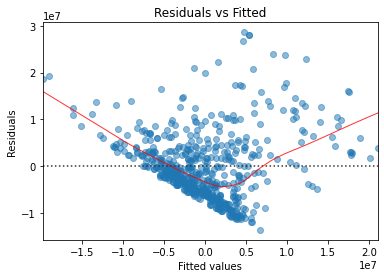

In [501]:
ax = plt.figure()
ax.axes[0] = sns.residplot(y=model.fittedvalues, x=model.resid, 
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

ax.axes[0].set_title('Residuals vs Fitted')
ax.axes[0].set_xlabel('Fitted values')
ax.axes[0].set_ylabel('Residuals');

Estimation for coefficients

In [502]:
print("From the residuals vs fitted plot, most the coefficients tend to be underestimated for larger "
      "absolute value of fitted values but overestimated for smaller absolute value of fitted values. Also, "
      "it is noted that the shape of the residual plot implies a non-linear relationship.")

From the residuals vs fitted plot, most the coefficients tend to be underestimated for larger absolute value of fitted values but overestimated for smaller absolute value of fitted values. Also, it is noted that the shape of the residual plot implies a non-linear relationship.


### Question 3b: Do you worry about heteroskedasticity? How can you detect and fix it if any?

Heteroskedasticity

In [503]:
# Breusch Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
bptest = sms.het_breuschpagan(model.resid, model.model.exog)
dict(zip(name, bptest))

{'Lagrange multiplier statistic': 103.8387284704925,
 'p-value': 6.996326315822745e-19,
 'f-value': 15.59251679459662,
 'f p-value': 7.914430633567428e-21}

In [504]:
print("From the residuals vs fitted plot, the spread of the residuals is not constant, hence heteroskedasticity "
      "is present. In addition, from the results of the Breusch-Pagan test, the p-value is < 0.05 and hence, "
      "we reject the null hypothesis of homoskedasticity. To fix this, we will use the White-Huber standard errors.")

From the residuals vs fitted plot, the spread of the residuals is not constant, hence heteroskedasticity is present. In addition, from the results of the Breusch-Pagan test, the p-value is < 0.05 and hence, we reject the null hypothesis of homoskedasticity. To fix this, we will use the White-Huber standard errors.


New OLS using White-Huber standard error

In [505]:
model_wh = sm.OLS(ols_y, sm.add_constant(pd.DataFrame(final_ols_X))).fit(cov_type="HC0")

### Question 3c: Do you worry about multicollinearity among your predictors? How can you quickly tell direction/strength of correlations among your variables?

Multicollinearity (Via Correlation Matrix)

In [506]:
final_ols_X.corr()

,pts,experience_YTD,ast,team_count,height,C,fg,3p%
pts,1.000000,0.181049,0.722688,-0.167692,-0.091057,-0.087425,0.989007,0.240138
experience_YTD,0.181049,1.000000,0.251107,0.140772,-0.025812,0.087331,0.170119,0.109238
ast,0.722688,0.251107,1.000000,-0.166076,-0.324641,-0.230914,0.702043,0.186566
team_count,-0.167692,0.140772,-0.166076,1.000000,0.233699,0.359760,-0.163951,-0.048338
height,-0.091057,-0.025812,-0.324641,0.233699,1.000000,0.640315,-0.057650,-0.236918
C,-0.087425,0.087331,-0.230914,0.359760,0.640315,1.000000,-0.046176,-0.295958
fg,0.989007,0.170119,0.702043,-0.163951,-0.057650,-0.046176,1.000000,0.200721
3p%,0.240138,0.109238,0.186566,-0.048338,-0.236918,-0.295958,0.200721,1.000000


### Question 3d: If there is strong evidence for multicollinearity, which method do you choose to alleviate it and why?

In [507]:
print("From the correlation matrix, we can see that 'pf', 'blk' and 'drb' has fairly high correlation which might "
      "result in multicollinearity. As such, we can use PCA to fix this as PCA projects the data into lower dimensional "
      "space while preserving the variation by using orthogonal linear combinations of the original data. However, "
      "we might lose interpretability after the use of PCA.")

From the correlation matrix, we can see that 'pf', 'blk' and 'drb' has fairly high correlation which might result in multicollinearity. As such, we can use PCA to fix this as PCA projects the data into lower dimensional space while preserving the variation by using orthogonal linear combinations of the original data. However, we might lose interpretability after the use of PCA.


### Question 4a: Which time-varying variables matter to explain player's salary?

Get panel data

In [510]:
df_panel = df_main.copy(deep=True)
#df_panel["pos"] = df_panel[pos_dummies.columns].idxmax(axis=1)
df_panel["season_year"] = df_panel[season_year_dummies.columns].idxmax(axis=1).astype(int)
df_panel = df_panel.drop(columns=list(season_year_dummies.columns))

Key columns

In [511]:
panel_key_cols = list(df_panel.columns)
panel_key_cols.remove("age")
panel_key_cols.remove("total_salary")
panel_key_cols.remove("player")
panel_key_cols.remove("season")
panel_key_cols.remove("pos")
panel_key_cols.remove("start_year")
panel_key_cols.remove("full_team_name")
panel_key_cols.remove("latest_year")
panel_key_cols.remove("team_location")
panel_key_cols.remove("experience")
panel_key_cols.remove("team_total_seasons")
panel_key_cols.remove("team_championships")
panel_key_cols.remove("team_playoff_appearances")
panel_key_cols.remove("team_g")
panel_key_cols.remove("team_mp")
panel_key_cols.remove("team_record")
panel_key_cols.remove("team_fg")
panel_key_cols.remove("tm")

In [512]:
df_panel = df_panel.loc[:, panel_key_cols]

Set index

In [513]:
season_year = pd.Categorical(df_panel["season_year"])
df_panel = df_panel.set_index(["team_name", "season_year"])
df_panel["season_year"] = season_year

Get exogeneous variables

In [514]:
exog_var = list(df_panel.columns)
exog_var.remove("season_year")
exog_var.remove("salary")
exog_var.remove("SG-PG")

In [515]:
exog = df_panel[exog_var]#.astype(float)
exog = sm.add_constant(exog)

Get endogeneous variable

In [516]:
endog = df_panel["salary"]

Fixed effect model

In [517]:
model_fe = PanelOLS(endog, exog, entity_effects = True, drop_absorbed=True)
fe_res = model_fe.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 salary   R-squared:                        0.5543
Estimator:                   PanelOLS   R-squared (Between):              0.1146
No. Observations:                6182   R-squared (Within):               0.5543
Date:                Sun, Mar 06 2022   R-squared (Overall):              0.5512
Time:                        19:19:30   Log-likelihood                -1.032e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      118.30
Entities:                          30   P-value                           0.0000
Avg Obs:                       206.07   Distribution:                 F(64,6088)
Min Obs:                       170.00                                           
Max Obs:                       251.00   F-statistic (robust):             118.30
                            

Random effect model

In [518]:
model_re = RandomEffects(endog, exog)
re_res = model_re.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 salary   R-squared:                        0.5524
Estimator:              RandomEffects   R-squared (Between):              0.3958
No. Observations:                6182   R-squared (Within):               0.5535
Date:                Sun, Mar 06 2022   R-squared (Overall):              0.5524
Time:                        19:19:30   Log-likelihood                -1.032e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      117.95
Entities:                          30   P-value                           0.0000
Avg Obs:                       206.07   Distribution:                 F(64,6117)
Min Obs:                       170.00                                           
Max Obs:                       251.00   F-statistic (robust):             117.95
                            

Get significant variables

In [519]:
# Fixed effect
fe_pvalues = fe_res.pvalues
fe_sig_cols = list(fe_pvalues[fe_pvalues<sig_val].index)
print("Significant variables (FE): {}".format(fe_sig_cols))

# Random effect
re_pvalues = re_res.pvalues
re_sig_cols = list(re_pvalues[re_pvalues<sig_val].index)
print("Significant variables (RE): {}".format(re_sig_cols))

Significant variables (FE): ['g', 'gs', 'mp', 'fg%', '3p%', 'efg%', 'ft%', 'ast', 'blk', 'pf', 'height', 'weight', 'experience_YTD', 'team_2pa', 'team_ft%', 'team_count', 'age_YTD']
Significant variables (RE): ['g', 'gs', 'mp', 'fg%', '3p%', 'efg%', 'ft%', 'ast', 'blk', 'pf', 'weight', 'experience_YTD', 'team_fga', 'team_3pa', 'team_2pa', 'team_2p%', 'team_stl', 'team_count', 'age_YTD']


### Question 4b: Which are time-invariant predictors in your data set? Do you worry about any fixed effect @i that might correlated with your predictors? If yes, provide examples of such fixed effects.

Time-invariant predictors

In [520]:
exog.columns

Index(['const', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p',
       '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'height', 'weight', 'experience_YTD',
       'team_fga', 'team_fg%', 'team_3p', 'team_3pa', 'team_3p%', 'team_2p',
       'team_2pa', 'team_2p%', 'team_ft', 'team_fta', 'team_ft%', 'team_orb',
       'team_drb', 'team_trb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
       'team_pf', 'team_pts', 'team_count', 'age_YTD', 'C', 'C-PF', 'PF',
       'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-C', 'SF-PF', 'SF-SG', 'SG',
       'SG-PF', 'SG-SF'],
      dtype='object')

In [521]:
print("Time-invariant variables: {}".format(["height", "weight"]))

Time-invariant variables: ['height', 'weight']


In [522]:
print("No. No fixed effect alpha i is correlated with the predictors.")

No. No fixed effect alpha i is correlated with the predictors.


### Question 4c: Which model of panel analysis do you choose, "fixed-effect" or random effect models and why?

Hausman test

In [523]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print("chi-Squared: {}".format(str(hausman_results[0])))
print("degrees of freedom: {}".format(str(hausman_results[1])))
print("p-Value: {}".format(str(hausman_results[2])))

chi-Squared: 57.101534383960164
degrees of freedom: 65
p-Value: 0.7466062480194186


In [524]:
print("Since p-value of Hausman test > 0.05, we accept the null hypothesis of using RandomEffect model.")

Since p-value of Hausman test > 0.05, we accept the null hypothesis of using RandomEffect model.


### Question 4d: Based on your results, what do you recommend to the team owner? How much should team pay existing players?

Recommendation

In [525]:
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 salary   R-squared:                        0.5524
Estimator:              RandomEffects   R-squared (Between):              0.3958
No. Observations:                6182   R-squared (Within):               0.5535
Date:                Sun, Mar 06 2022   R-squared (Overall):              0.5524
Time:                        19:19:30   Log-likelihood                -1.032e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      117.95
Entities:                          30   P-value                           0.0000
Avg Obs:                       206.07   Distribution:                 F(64,6117)
Min Obs:                       170.00                                           
Max Obs:                       251.00   F-statistic (robust):             117.95
                            

Get coefficients of significant variables

In [526]:
re_coeff = re_res.params[re_pvalues<sig_val]
re_coeff = re_coeff.to_frame().reset_index(drop=False)
re_coeff.columns = ["predictor", "coefficient"]

In [527]:
for i, row in re_coeff.iterrows():
    predictor = row["predictor"]
    coefficient = row["coefficient"]
    
    print("On average, for every unit increase in {}, increase the players pay by ${}".format(
          predictor, round(coefficient, 2)))

On average, for every unit increase in g, increase the players pay by $-24838.68
On average, for every unit increase in gs, increase the players pay by $25288.38
On average, for every unit increase in mp, increase the players pay by $-116919.98
On average, for every unit increase in fg%, increase the players pay by $8960859.82
On average, for every unit increase in 3p%, increase the players pay by $-1249183.64
On average, for every unit increase in efg%, increase the players pay by $-13489930.29
On average, for every unit increase in ft%, increase the players pay by $-1478278.38
On average, for every unit increase in ast, increase the players pay by $774425.15
On average, for every unit increase in blk, increase the players pay by $1081411.27
On average, for every unit increase in pf, increase the players pay by $-902110.8
On average, for every unit increase in weight, increase the players pay by $43674.74
On average, for every unit increase in experience_YTD, increase the players pay 

### Question 5a: Do you think your result could be interpreted in a causal relationship? Why or why not?

### Question 5b: Winning a game is a team effort, but solely that of a single player. If the objective is to win, how can your prediction include cooperation amongst members?

In [528]:
print("We can include coorperation amongst members by adding the average statistics of the players in the team "
      "and statistics of assists as exogeneous variables.")

We can include coorperation amongst members by adding the average statistics of the players in the team and statistics of assists as exogeneous variables.
